## supervisor second sampling
* need random sample of the sample i have extracted, so the supervisors can check what i am doing

In [13]:
import numpy as np
import pandas as pd
import os
#from PIL import Image
from glob import glob
import csv
import matplotlib.pyplot as plt
from IPython.display import clear_output
import math
import shutil

from numba import jit
import h5py
import random
from scipy.stats import iqr

In [6]:
path_to_1000_sample = '/gws/nopw/j04/dcmex/users/ezriab/image_labelling/2ds_10000_sample/2ds_10000_new_2nd_fixed_dup.csv'
all_2ds_stats_path = '/gws/nopw/j04/dcmex/users/ezriab/processed_stats/2ds/all_2ds_v4_dup_updated.csv'

image_labelled_df = pd.read_csv(path_to_1000_sample)
full_ds_stats = pd.read_csv(all_2ds_stats_path)

# combine the samples + label with stats 
image_labelled_df = image_labelled_df.rename(columns={'image_name': 'name'}) # need to rename our column, so they merge nicely
images_labelled_lst = list(image_labelled_df['name'])
labelled_image_stats = full_ds_stats[full_ds_stats['name'].isin(images_labelled_lst)] # extract the ones labelled
merged_df = pd.merge(labelled_image_stats, image_labelled_df, on='name', how='left')  # merge them together

## save this 
save_merged = '/gws/nopw/j04/dcmex/users/ezriab/image_labelling/2ds_10000_sample/2ds_10000_new_2nd_fixed_dup_stats.csv'
#merged_df.to_csv(save_merged, index=False)

name    date  slice_s_idx  slice_e_idx          start_time  \
0         14074_19ch0  220719        14074        14104  18:33:00.242000000   
1         14105_19ch0  220719        14105        14140  18:33:00.242000000   
2         14141_19ch0  220719        14141        14160  18:33:00.258000000   
3         19203_19ch0  220719        19203        19228  18:36:37.036000000   
4         19527_19ch0  220719        19527        19548  18:36:37.130000000   
...               ...     ...          ...          ...                 ...   
9994     596756_08ch1  220808       596756       596818  18:49:53.953000000   
9995     607749_08ch1  220808       607749       607788  18:55:04.393000000   
9996     612100_08ch1  220808       612100       612156  18:55:10.259000000   
9997     624334_08ch1  220808       624334       624401  18:55:26.967000000   
9998  2484896_1_25ch1  220725      2484896      2484919             37:49.1   

                end_time  ellipse_d_max  Euclidean_d_max  Feret_d_max  \
0     18:33:00.242000000     332.134410       361.247837   378.021163   
1     18:33:00.258000000     462.141937       496.487663   505.964426   
2     18:33:00.258000000     510.132076       488.364618   498.196748   
3     18:36:37.052000000     322.356992       341.760150   354.682957   
4     18:36:37.161000000     279.010697       322.024844   331.058907   
...                  ...            ...              ...          ...   
9994  18:49:54.343000000     712.419798       762.364742   775.241898   
9995  18:55:04.393000000     601.671874       598.080262   610.327781   
9996  18:55:10.306000000     794.549027       842.140131   854.751426   
9997  18:55:26.967000000     701.105054       677.421582   688.839604   
9998             37:49.1     331.417465       317.804972   331.209903   

          area  ...  image_trunc  aspect_ratio    wind_w       pres  \
0      48900.0  ...            0      1.481493 -0.489167  399.62808   
1      59400.0  ...            0      1.729976 -0.489167  399.62808   
2      63200.0  ...            0      2.998836 -0.489167  399.62808   
3      52100.0  ...            0      1.459482 -5.357894  364.98770   
4      37800.0  ...            0      1.385861 -5.357894  364.98770   
...        ...  ...          ...           ...       ...        ...   
9994  314000.0  ...            0      1.246114 -0.375260  504.18872   
9995  151400.0  ...            0      1.766831 -3.568416  502.59546   
9996  321800.0  ...            0      1.517214 -3.838890  502.67065   
9997  102000.0  ...            0      3.249910 -2.674403  502.33282   
9998   43200.0  ...            0      1.575712 -0.382931  380.90970   

            alt       temp       LWC       IWC  number_label  note  
0     7669.0723  256.24040  0.024554  0.007184             2   NaN  
1     7669.0723  256.24040  0.017039  0.003739             4   NaN  
2     7669.0723  256.24040  0.028536  0.000000             1   NaN  
3     8345.3170  252.29915  0.539022  0.228249             1   NaN  
4     8345.3170  252.29915  1.022519  0.051016             2   NaN  
...         ...        ...       ...       ...           ...   ...  
9994  5839.3564  266.25952  0.221041  0.007129             1   NaN  
9995  5867.9443  266.56476  0.000000  0.005845             1   NaN  
9996  5866.6367  266.48633  0.071153  0.034108             1   NaN  
9997  5870.0350  266.30496  1.270076  0.000000             0   NaN  
9998  7979.3060  256.33566  0.006337  0.284747             0   NaN  

[9999 rows x 25 columns]

In [41]:
def quick_hist_bx(df, variable, units = None, opt_title= None, n_bins = 50):
    fig, axs = plt.subplots(2,1,gridspec_kw={"height_ratios": (0.90, 0.1)}, figsize=(16, 6), tight_layout=True)
    data = df[variable]
    ax_hist = axs[0] # The histogram axis
    ax_box = axs[1]   # The boxplot axis
    
    # Plot histogram
    ax_hist.hist(data, bins=n_bins, edgecolor='black')
    ax_hist.set_ylabel('count')
    
    if units:
        ax_hist.set_xlabel(units)
    
    if opt_title:
        ax_hist.set_title(f'2ds {opt_title} {variable}')

    else:
        ax_hist.set_title(f'2ds {variable}')
    
    # Plot boxplot
    ax_box.axis('off') 
    outlier = dict(marker = 'x')
    ax_box.boxplot(data, vert=False,  flierprops = outlier, widths = 0.6, notch=True, patch_artist=True)  # Horizontal boxplot
        
    plt.show()

def quick_pie(df):
    labels = [0,1,2,3,4,6,7,8,9]
    category_dic = {'1':['CP'],'2':['FA'],'3':['Co'],'4':['HPC'],'6':['CBC'],'7':['CA'],'8':['CC'],'9':['WD'],'0':['DIF']}
    for label in labels:
        number_samples = df[df['number_label'] == label]
        samplecount= number_samples['name'].count()
        category_dic[str(label)].append(samplecount)
    
    name_list = [value[0] for value in category_dic.values()]
    count_list = [value[1] for value in category_dic.values()]
    
    fig, ax = plt.subplots()
    ax.pie(count_list, labels= name_list)

    

## assuming to use name_list_of_sample + merged_df
def rand_sample_df(n_sample):
    random.seed(42) # !! v important, means we choose same set images every time. 
    sample_list = random.sample(name_list_of_sample, k=n_sample)
    sampled_df = merged_df[merged_df['name'].isin(sample_list)] # extract the ones labelled
    return sampled_df

In [15]:
merged_df_path = '/gws/nopw/j04/dcmex/users/ezriab/image_labelling/2ds_10000_sample/2ds_10000_new_2nd_fixed_dup_stats.csv'
merged_df = pd.read_csv(merged_df_path)
name_list_of_sample = list(merged_df['name'])

In [24]:
## do random sample
merged_df_1000_sample = rand_sample_df(1000)
merged_df_500_sample = rand_sample_df(500)
merged_df_250_sample = rand_sample_df(250)

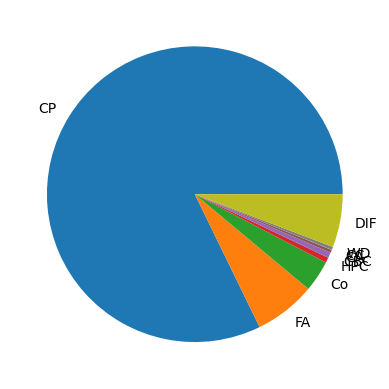

In [42]:
variable = 'Euclidean_d_max'
#quick_hist_bx(merged_df,variable, opt_title= 'full 10000 sample')#, plt_units)
quick_pie(merged_df)

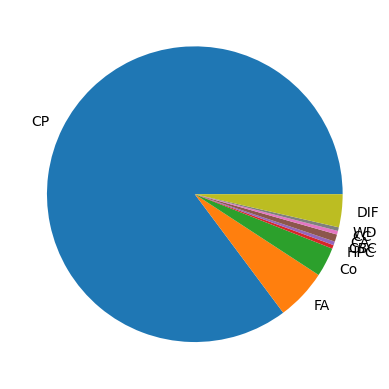

In [43]:
#quick_hist_bx(merged_df_250_sample,variable, opt_title= '250 sample')#, plt_units)
quick_pie(merged_df_250_sample)

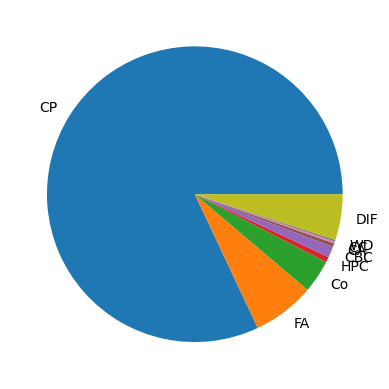

In [45]:
#quick_hist_bx(merged_df_500_sample,variable, opt_title= '500 sample')#, plt_units)
quick_pie(merged_df_500_sample)

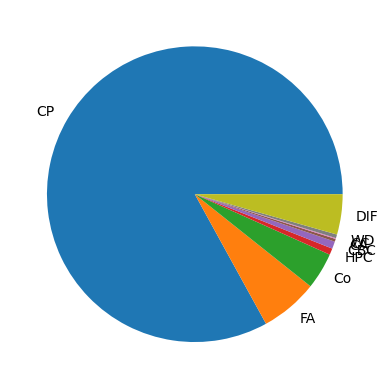

In [46]:
#quick_hist_bx(merged_df_1000_sample,variable, opt_title= '1000 sample')#, plt_units)
quick_pie(merged_df_1000_sample)

In [37]:
#merged_df


([<matplotlib.patches.Wedge at 0x7fa09c9c0a50>,
 [Text(-0.9327796767121046, 0.5830283652729613, 'CP'),
  Text(0.6784797994035788, -0.8658320632786012, 'FA'),
  Text(0.9153480267757444, -0.6100311384493019, 'Co'),
  Text(0.9844394222142724, -0.4907942786855097, 'HPC'),
  Text(1.001954719699567, -0.4539677738251495, 'CBC'),
  Text(1.0145230004032684, -0.42513889689459144, 'CA'),
  Text(1.0188763549647215, -0.41459736286402377, 'CC'),
  Text(1.0233738511047765, -0.4033682695440714, 'WD'),
  Text(1.0817234318752895, -0.19968579551872526, 'DIF')])

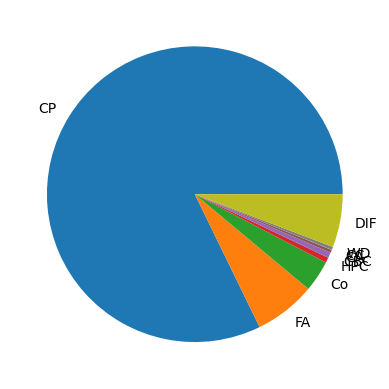

In [35]:
#name_list = [value[0] for key in category_dic[key]]


In [36]:
name_list

['CP', 'FA', 'Co', 'HPC', 'CBC', 'CA', 'CC', 'WD', 'DIF']